In [1]:
import pickle
with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

In [8]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def find_local_maxima(matrix):
    def is_local_maxima(matrix, i, j):
        rows, cols = matrix.shape
        value = matrix[i, j]
        if np.isnan(value):
            return False
        def is_valid_and_greater_than(value, neighbor):
            return not np.isnan(neighbor) and neighbor > value
        if i > 0 and is_valid_and_greater_than(value, matrix[i - 1, j]):
            return False
        if i < rows - 1 and is_valid_and_greater_than(value, matrix[i + 1, j]):
            return False
        if j > 0 and is_valid_and_greater_than(value, matrix[i, j - 1]):
            return False
        if j < cols - 1 and is_valid_and_greater_than(value, matrix[i, j + 1]):
            return False
        if i > 0 and j > 0 and is_valid_and_greater_than(value, matrix[i - 1, j - 1]):
            return False
        if i > 0 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i - 1, j + 1]):
            return False
        if i < rows - 1 and j > 0 and is_valid_and_greater_than(value, matrix[i + 1, j - 1]):
            return False
        if i < rows - 1 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i + 1, j + 1]):
            return False
        return True
    i_max, j_max, value_max = [], [], []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if is_local_maxima(matrix, i, j):
                i_max.append(i)
                j_max.append(j)
                value_max.append(matrix[i, j])
    return i_max, j_max, value_max

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def get_variable_name(var):
    for name, value in globals().items():
        if value is var:
            return name
    return None

def make_cartesian(lon, lat, theta0, phi0):
    lonr = np.deg2rad(lon)
    latr = np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(phi0) * (lonr - theta0)
    y = r_earth * (latr - phi0)
    return x, y

def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x/1000, y/1000

def rotate_30_clockwise(x, y):
    theta = np.deg2rad(30)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

def extract_contour(level_to_extract, plot):
    for level_paths in plot.allsegs:
        for path in level_paths:
            xt = path[:, 0]
            yt = path[:, 1]
            return xt, yt
    else:
        return [], []

In [4]:
edata = eddies['Eddy17'].iloc[3] #E22T5
t = extract_number(edata.name)

mcolor = 'r' if edata.Vort > 0 else 'c'
colormap = 'Reds' if edata.Vort > 0 else 'Blues'

temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:
    
    fnumber = '0'+str(round(1461+ file_idx*30))
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_'+fnumber+'.nc'
    dataset = nc.Dataset(fname)
    
    U = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
    V = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
    Vorticity = np.load('/srv/scratch/z5297792/Climatology/vorts/vort_'+fnumber+'.npy')
    TemperatureAnomaly = np.load('/srv/scratch/z5297792/Climatology/temps/temp_'+fnumber+'.npy') - np.repeat(temp_ave[:, :, :, np.newaxis], 30, axis=3)
    CurSpeed = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_'+fnumber+'.npy')
    CurSpeedAnomaly = CurSpeed - np.repeat(CurSpeed_ave[:, :, :, np.newaxis], 30, axis=3)
    OW = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/ow_'+fnumber+'.npy')
    ocean_time = dataset.variables['ocean_time'][:]
    
    previous_file_idx = file_idx

In [5]:
SEARCH_WIDTH = 200000
i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)
x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)


In [9]:
DEPTH_LVL = 5

x, y, uu, vv = lon_rho, lat_rho, U[:,:,DEPTH_LVL,t_mod], V[:,:,DEPTH_LVL,t_mod]

#----------------------------------------
# Calculation of eddy kinetic energy
ke = (uu**2 + vv**2) / 2

#----------------------------------------
# Calculation of finite spatial element
dx  = np.zeros_like(x)
dy  = np.zeros_like(x)
dux = np.zeros_like(x)
duy = np.zeros_like(x)
dvx = np.zeros_like(x)
dvy = np.zeros_like(x)

#----------------------------------------
# Spatial element in degrees if grid_ll==1 or in km otherwise
dx[1:-1, 1:-1] = x[1:-1, 2:] - x[1:-1, :-2]
dy[1:-1, 1:-1] = y[2:, 1:-1] - y[:-2, 1:-1]

# if grid_ll: yes we are using earth coordinates in deg (lon,lat)
# Define constants
earth_radius = 6378.137  # km
# Kilometers (km) per degree of latitude
R = earth_radius * np.pi / 180  # ~111.320 km
# Calculate finite spatial element in km
dx = dx * R * np.cos(np.radians(y))
dy = dy * R

# Convert to meters
dx = dx * 1000  # m
dy = dy * 1000  # m

#----------------------------------------
# Compute speed element in m/s
dux[1:-1, 1:-1] = uu[1:-1, 2:] - uu[1:-1, :-2]
duy[1:-1, 1:-1] = uu[2:, 1:-1] - uu[:-2, 1:-1]
dvx[1:-1, 1:-1] = vv[1:-1, 2:] - vv[1:-1, :-2]
dvy[1:-1, 1:-1] = vv[2:, 1:-1] - vv[:-2, 1:-1]

#----------------------------------------
# Calculation of Okubo-Weiss criteria
sn = (dux / dx) - (dvy / dy)  # shear "cisaillement"
ss = (dvx / dx) + (duy / dy)  # strain "deformation"
om = (dvx / dx) - (duy / dy)  # vorticity "vorticité"

okubo = sn**2 + ss**2 - om**2  # in s^-2

#----------------------------------------
# Calculation of divergence
div = (dux / dx) + (dvy / dy)

#----------------------------------------
# Calculation of vorticity field (typically +/-10^-5 s^-1)
vorticity = om * np.sign(f)

#----------------------------------------
# Border is a parameter which prevents the constraints
# from being applied to points too close to the domain boundaries
# which would result in an index error
b = np.ones_like(x, dtype=int)
borders = np.max(b) + 1


# Initialization
L = np.zeros_like(uu)
LOW = np.full_like(uu, np.nan)

#----------------------------------------
# Calculate LNAM and LOW in all domain pixels
for i in range(borders, len(vv[:, 0]) - borders + 1):
    for j in range(borders, len(vv[0, :]) - borders + 1):

        if not np.isnan(vv[i, j]):

            # Calculate LOW
            OW = okubo[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
            LOW[i, j] = np.nanmean(OW)

            # Calculate LNAM
            xlocal = x[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
            ylocal = y[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]

            ulocal = uu[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
            vlocal = vv[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]

            # Local Normalized Angular Momentum
            # Use the middle of the square as center coordinate

            coordcentre = (xlocal.shape[0] - 1) // 2

            # if grid_ll:
            d_xcentre = (xlocal - xlocal[coordcentre, coordcentre]) * R * np.cos(np.radians(ylocal))
            d_ycentre = (ylocal - ylocal[coordcentre, coordcentre]) * R
            # else:
            #     d_xcentre = (xlocal - xlocal[coordcentre, coordcentre])
            #     d_ycentre = (ylocal - ylocal[coordcentre, coordcentre])

            cross = (d_xcentre * vlocal) - (d_ycentre * ulocal)
            dot = (ulocal * d_xcentre) + (vlocal * d_ycentre)
            produit = np.sqrt(ulocal**2 + vlocal**2) * np.sqrt(d_xcentre**2 + d_ycentre**2)
            sumdp = np.sum(dot) + np.sum(produit)

            if sumdp != 0:
                L[i, j] = np.sum(cross) / sumdp * np.sign(f[i, j])
            else:
                L[i, j] = 0

# Replace NaNs with zeros
L[np.isnan(L)] = 0



Text(0.5, 1.0, 'LNAM')

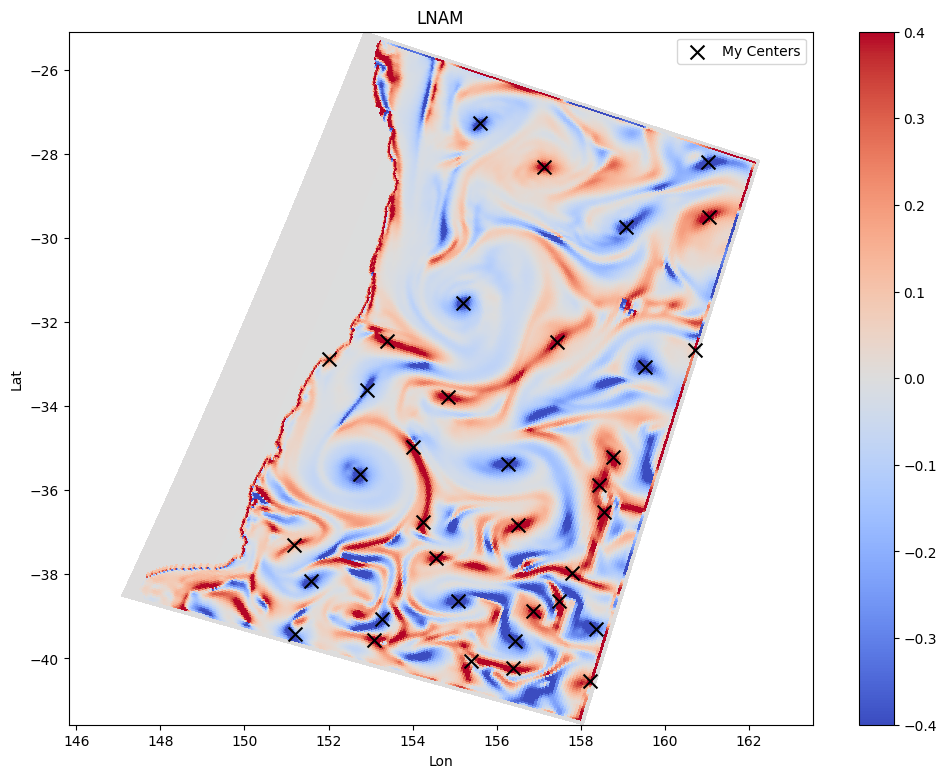

In [17]:
xdim, ydim = x.shape

xx = np.arange(xdim)
yy = np.arange(ydim)

xx, yy = np.meshgrid(xx,yy)

plt.figure(figsize=(12,9))

plt.pcolor(lon_rho[xx,yy], lat_rho[xx,yy], L[xx,yy], vmin=-.4,vmax=.4, cmap='coolwarm')
plt.colorbar()

daydic['Day'+str(t_mod+1)].plot(ax=plt.gca(), kind='scatter', x='Lon', y='Lat', marker='x', color='k', label='My Centers', s=100)
plt.axis('equal')
plt.title('LNAM')
